In [2]:
!pip install pywaffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 61.8 MB/s eta 0:00:00


In [6]:
# --- Importation des librairies ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import warnings
import os
import yellowbrick
import scipy.cluster.hierarchy as shc
import matplotlib.patches as patches

from matplotlib.patches import Rectangle
from pandas_profiling import ProfileReport
from pywaffle import Waffle
from math import isnan
from random import sample
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette
from yellowbrick.contrib.wrapper import wrap

# --- Configuration des librairies ---
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 600
sns.set(rc = {'axes.facecolor': '#FBFBFB', 'figure.facecolor': '#FBFBFB'})
class clr:
    start = '\033[93m'+'\033[1m'
    color = '\033[93m'
    end = '\033[0m'

In [8]:
df = pd.read_excel("../data/donnees_selectionnees.xlsx")
k_means_results =  np.loadtxt("../data/kmeans_results.txt")
k_means_results = [i+1 for i in k_means_results]
df = df[df.columns[1:]]

In [10]:
# --- Add K-Means Prediction to Data Frame ----

df['cluster_result'] = k_means_results
df['cluster_result'] = 'Cluster '+df['cluster_result'].astype(str)

# --- Calculationg Overall Mean from Current Data Frame ---
df_profile_overall = pd.DataFrame()
df_profile_overall['Overall'] = df.describe().loc[['mean']].T

# --- Summarize Mean of Each Clusters --- 
df_cluster_summary = df.groupby('cluster_result').describe().T.reset_index().rename(columns={'level_0': 'Column Name', 'level_1': 'Metrics'})
df_cluster_summary = df_cluster_summary[df_cluster_summary['Metrics'] == 'mean'].set_index('Column Name')
df_profile = pd.read_excel("../data/profilage.xlsx")
df_profile.style.background_gradient(cmap='YlOrBr').hide_index()

Column Name,Metrics,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Overall
BALANCE,mean,3401.840056,1012.915503,824.180354,4510.612798,1564.474828
BALANCE_FREQUENCY,mean,0.988427,0.799792,0.919997,0.963486,0.877271
PURCHASES,mean,6894.613917,223.081279,1236.499406,462.647357,1003.204834
ONEOFF_PURCHASES,mean,4511.889901,157.576608,621.738764,300.127390,592.437371
INSTALLMENTS_PURCHASES,mean,2383.916859,65.833785,614.965725,162.619301,411.067645
CASH_ADVANCE,mean,773.154467,614.588758,147.442197,4401.478579,978.871112
PURCHASES_FREQUENCY,mean,0.954443,0.190099,0.862440,0.266258,0.490351
ONEOFF_PURCHASES_FREQUENCY,mean,0.726667,0.074901,0.301883,0.129829,0.202458
PURCHASES_INSTALLMENTS_FREQUENCY,mean,0.808946,0.109962,0.675116,0.166187,0.364437
CASH_ADVANCE_FREQUENCY,mean,0.084806,0.122459,0.030698,0.470904,0.135144


In [11]:
df.to_excel("../data/donnees_labelisees.xlsx")

<div class="explain-box">
    Based on the table above, it can be concluded that each cluster has the following <mark><b>characteristics</b></mark>:
    <blockquote style="color: #000000;">
<ul>
            <li><mark style="font-weight: bold; background-color: #FFBB00">Cluster 1 (<u>Utilisateurs payeurs complets</u>)</mark>: Les clients de ce groupe sont des <mark style="font-weight: bold; background-color: #FFBB00"><b>utilisateurs actifs de la carte de crédit de la banque</b></mark>.<br> Cela se voit à la fréquence du <b>solde qui change fréquemment</b> et que le <b>montant des soldes est assez élevé</b> par rapport aux autres groupes.<br> De plus, comparé aux autres groupes, <b>ce groupe présente des valeurs moyennes plus élevées dans plusieurs aspects</b>.<br> Les clients de cartes de crédit dans ce groupe <b>utilisent activement les cartes de crédit pour faciliter les transactions et les versements échelonnés</b>. Les <b>avances de fonds, les transactions et les versements échelonnés dans ce groupe se produisent également plus fréquemment</b>. Le <b>fait que le score de crédit dans ce groupe soit très bon est également indiqué par l'ancienneté relativement élevée</b>.</li> <br><br>
<li><mark style="font-weight: bold; background-color: #3C096C; color: #FFFFFF;">Cluster 2 (<u>Utilisateurs débutants/étudiants</u>)</mark> : Contrairement au cluster 1, <mark style="font-weight: bold; background-color: #3C096C; color: #FFFFFF;"><b>les clients utilisent rarement, voire jamais, leur carte de crédit pour les transactions et les versements échelonnés</b></mark> dans ce groupe. Cela est dû au fait que le client <b>dispose d'un solde relativement faible, la fréquence de changement du solde est rare et les versements sont très faibles</b>. De plus, une <b>limite de crédit faible</b> montre également que <b>les clients utilisent rarement, voire jamais, leur carte de crédit pour effectuer des transactions de crédit</b>, et les clients de ce groupe <b>font également rarement des avances de fonds</b>. Ainsi, <mark style="font-weight: bold; background-color: #3C096C; color: #FFFFFF;"><b>on peut supposer que les clients n'utilisent leur carte de crédit que pour les avances de fonds avec une fréquence suffisante</b></mark>. De plus, le faible solde permet aux clients de ce groupe <mark style="font-weight: bold; background-color: #3C096C; color: #FFFFFF;"><b>d'être des étudiants ou de nouveaux utilisateurs qui utilisent des cartes de crédit dans cette banque</b></mark>.</li><br><br>
        <li><mark style="font-weight: bold; background-color: #9D4EDD; color: #FFFFFF;">Cluster 3 (<u>Utilisateurs de versements échelonnés</u>)</mark>: Dans ce cluster, les clients utilisent des cartes de crédit <mark style="font-weight: bold; background-color: #9D4EDD; color: #FFFFFF;"><b>spécifiquement pour des transactions avec des versements échelonnés</b></mark>. Cela est dû au <b>niveau relativement élevé de transactions utilisant des versements échelonnés dans ce cluster</b>. De plus, les clients de ce groupe <b>effectuent souvent des transactions avec des montants très élevés par transaction et la fréquence et les transactions d'avances de fonds sont très faibles</b>. Les clients de ce groupe <b>effectuent très rarement des paiements et des avances de fonds et ont une fréquence et un montant d'avances de fonds relativement faibles</b>. On peut conclure que les <mark style="font-weight: bold; background-color: #9D4EDD; color: #FFFFFF;"><b>clients de ce cluster conviennent parfaitement aux cartes de crédit spécifiquement conçues pour les besoins en versements échelonnés</b></mark>.</li><br><br>
            <li><mark style="font-weight: bold; background-color: #FFE270">Cluster 4 (<u>Utilisateurs de retraits/avances de fonds</u>)</mark>: Les clients de ce groupe ont <b>des soldes élevés, des soldes dont la fréquence de changement est toujours en mouvement et une fréquence élevée de retraits et d'avances de fonds</b>. De plus, les clients de ce groupe ont les <b>taux d'intérêt les plus bas par rapport aux autres groupes et ont le deuxième plus haut plafond de crédit et les paiements les plus élevés</b> des quatre groupes. Cependant, les utilisateurs de cartes de crédit dans ce groupe <b>font rarement des achats en versements ou des achats uniques et ont le troisième plus haut taux d'ancienneté</b> des quatre groupes. Ainsi, on peut conclure que <mark style="font-weight: bold; background-color: #FFE270"><b>les clients de ce groupe n'utilisent les cartes de crédit que pour les besoins de retrait d'argent ou d'avances de fonds</b></mark>.</li>
        </ul>
    </blockquote>
    Voici quelques <mark><b>visualisations</b></mark> de deux variables dans chaque cluster :
</div>


In [12]:
# --- Cluster Visualization 1: Variables ---
scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.75)
sub_scatter_style_color=dict(s=5, alpha=0.65, linewidth=0.15, zorder=10, edgecolor='#100C07')
sub_scatter_style_grey=dict(s=5, alpha=0.3, linewidth=0.7, zorder=5, color='#CAC9CD')
grid_style=dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
xy_label=dict(fontweight='bold', fontsize=14, fontfamily='serif')
suptitle=dict(fontsize=20, fontweight='heavy', fontfamily='serif')
title=dict(fontsize=14, fontfamily='serif')
color_pallete=['#FFBB00', '#3C096C', '#9D4EDD', '#FFE270']
sub_axes=[None] * 4

# --- Cluster Visualization 1: Data Frame ---
df_cv1 = df[['CREDIT_LIMIT', 'BALANCE', 'cluster_result']]
cluster_result = sorted(df_cv1['cluster_result'].unique())

# --- Cluster Visualization 1: Settings ---
fig = plt.figure(figsize=(12, 16))
gs = fig.add_gridspec(4, 4)
ax = fig.add_subplot(gs[:4, :])
ax.set_aspect(1)

# --- Cluster Visualization 1: Main Scatter Plot ---
for x in range(len(cluster_result)):
    df_cv1_x = df_cv1[df_cv1['cluster_result']==cluster_result[x]]
    
    ax.scatter(df_cv1_x['CREDIT_LIMIT'], df_cv1_x['BALANCE'], s=80, color=color_pallete[x], **scatter_style)
    ax.set_title('Clusters 1 and 4 have the highest balance and credit limit compared to other clusters.\n', loc='left', **title)
    ax.set_xlabel('\nCREDIT_LIMIT', **xy_label)
    ax.set_ylabel('BALANCE\n', **xy_label)
    ax.grid(axis='y', which='major', **grid_style)
    ax.grid(axis='x', which='major', **grid_style)
    for spine in ax.spines.values():
        spine.set_color('None')
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#CAC9CD')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

# --- Cluster Visualization 1: Sub Plots ---
for idx, clstr in enumerate(cluster_result):
    sub_axes[idx] = fig.add_subplot(gs[3, idx], aspect=1)
    
    sub_axes[idx].scatter(df_cv1[df_cv1['cluster_result']!=clstr]['CREDIT_LIMIT'], df_cv1[df_cv1['cluster_result']!=clstr]['BALANCE'], label=clstr, **sub_scatter_style_grey)
    sub_axes[idx].scatter(df_cv1[df_cv1['cluster_result']==clstr]['CREDIT_LIMIT'], df_cv1[df_cv1['cluster_result']==clstr]['BALANCE'], color=color_pallete[idx], label=clstr, **sub_scatter_style_color)
    
    cnt = round((df_cv1['cluster_result']==clstr).sum()/8950*100, 2)
    sub_axes[idx].set_title(f'{clstr} - ({cnt}%)', loc='left', fontsize=9, fontfamily='serif')
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    for spine in sub_axes[idx].spines.values():
        spine.set_color('None')

# --- Cluster Visualization 1: Title ---
plt.suptitle('Credit Limit vs. Balance based on Clusters', x=0.123, y=0.74, ha='left', **suptitle)
plt.gcf().text(0.82, 0.13, 'KONE ALASSANE - AKILI', style='italic', fontsize=8)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

<div class="explain-box">
À partir de la figure ci-dessus, on peut voir que <b>les clusters 1 et 4 ont le solde et la limite de crédit les plus élevés</b>. <br><br> De plus, on peut constater que <mark><b>plus le solde augmente, plus le client obtient de limite de crédit</b></mark>. Cela est clairement visible dans les clusters 1 et 4 car ces clusters ont des clients qui sont <b>très actifs dans l'utilisation de cartes de crédit</b>.<br><br> Cependant, cela diffère des <b>clusters 2 et 3</b>, où il y a une <b>légère corrélation</b> entre les deux variables car les clients de ce cluster ont une <b>fréquence de mise à jour du solde assez rare</b>. De plus, on peut voir que <mark><b>la plupart des détenteurs de cartes avec un solde nul se trouvent dans les clusters 2 et 3</b></mark>.
</div>


In [13]:
# --- Cluster Visualization 2: Variables ---
scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.75)
sub_scatter_style_color=dict(s=5, alpha=0.65, linewidth=0.15, zorder=10, edgecolor='#100C07')
sub_scatter_style_grey=dict(s=5, alpha=0.3, linewidth=0.7, zorder=5, color='#CAC9CD')
grid_style=dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
xy_label=dict(fontsize=11, fontweight='bold', fontfamily='serif')
suptitle=dict(fontsize=14, fontweight='heavy', fontfamily='serif')
title=dict(fontsize=12, fontfamily='serif')
color_pallete=['#FFBB00', '#3C096C', '#9D4EDD', '#FFE270']
sub_axes=[None] * 4

# --- Cluster Visualization 2: Data Frame ---
df_cv2 = df[['CREDIT_LIMIT', 'ONEOFF_PURCHASES', 'cluster_result']]
cluster_result = sorted(df_cv1['cluster_result'].unique())

# --- Cluster Visualization 2: Settings ---
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 4)
ax = fig.add_subplot(gs[:4, :4])
ax.set_aspect(1)

# --- Cluster Visualization 2: Main Scatter Plot ---
for x in range(len(cluster_result)):
    df_cv2_x = df_cv2[df_cv2['cluster_result']==cluster_result[x]]
    
    ax.scatter(df_cv2_x['CREDIT_LIMIT'], df_cv2_x['ONEOFF_PURCHASES'], s=80, color=color_pallete[x], **scatter_style)
    ax.set_title('There is no correlation between the one-off purchase amount and the credit limit\nobtained.\n', loc='left', **title)
    ax.set_xlabel('\nCREDIT_LIMIT', **xy_label)
    ax.set_ylabel('ONEOFF_PURCHASES\n', **xy_label)
    ax.grid(axis='y', which='major', **grid_style)
    ax.grid(axis='x', which='major', **grid_style)
    for spine in ax.spines.values():
        spine.set_color('None')
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#CAC9CD')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# --- Cluster Visualization 2: Sub Plots ---
for idx, clstr in enumerate(cluster_result):
    sub_axes[idx] = fig.add_subplot(gs[idx, 3], aspect=1)
    
    sub_axes[idx].scatter(df_cv2[df_cv2['cluster_result']!=clstr]['CREDIT_LIMIT'], df_cv2[df_cv2['cluster_result']!=clstr]['ONEOFF_PURCHASES'], label=clstr, **sub_scatter_style_grey)
    sub_axes[idx].scatter(df_cv2[df_cv2['cluster_result']==clstr]['CREDIT_LIMIT'], df_cv2[df_cv2['cluster_result']==clstr]['ONEOFF_PURCHASES'], color=color_pallete[idx], label=clstr, **sub_scatter_style_color)
    
    cnt = round((df_cv2['cluster_result']==clstr).sum()/8950*100, 2)
    sub_axes[idx].set_title(f'{clstr} - ({cnt}%)', loc='left', fontsize=7, fontfamily='serif')
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    for spine in sub_axes[idx].spines.values():
        spine.set_color('None')

# --- Cluster Visualization 2: Title ---
plt.suptitle('One-off Purchase vs. Credit Limit based on Clusters', x=0.28, y=0.97, ha='left', **suptitle)
plt.gcf().text(0.77, 0.01, 'KONE ALASSANE - AKILI', style='italic', fontsize=8)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

<div class="explain-box">
<mark><b>L'achat ponctuel n'affecte pas la limite de crédit supplémentaire obtenue par l'utilisateur</b></mark>.<br> Sur la figure ci-dessus et comme mentionné précédemment, on peut voir que <b>le cluster 1 a un client avec le montant d'achat le plus élevé pour une transaction</b>.
</div>


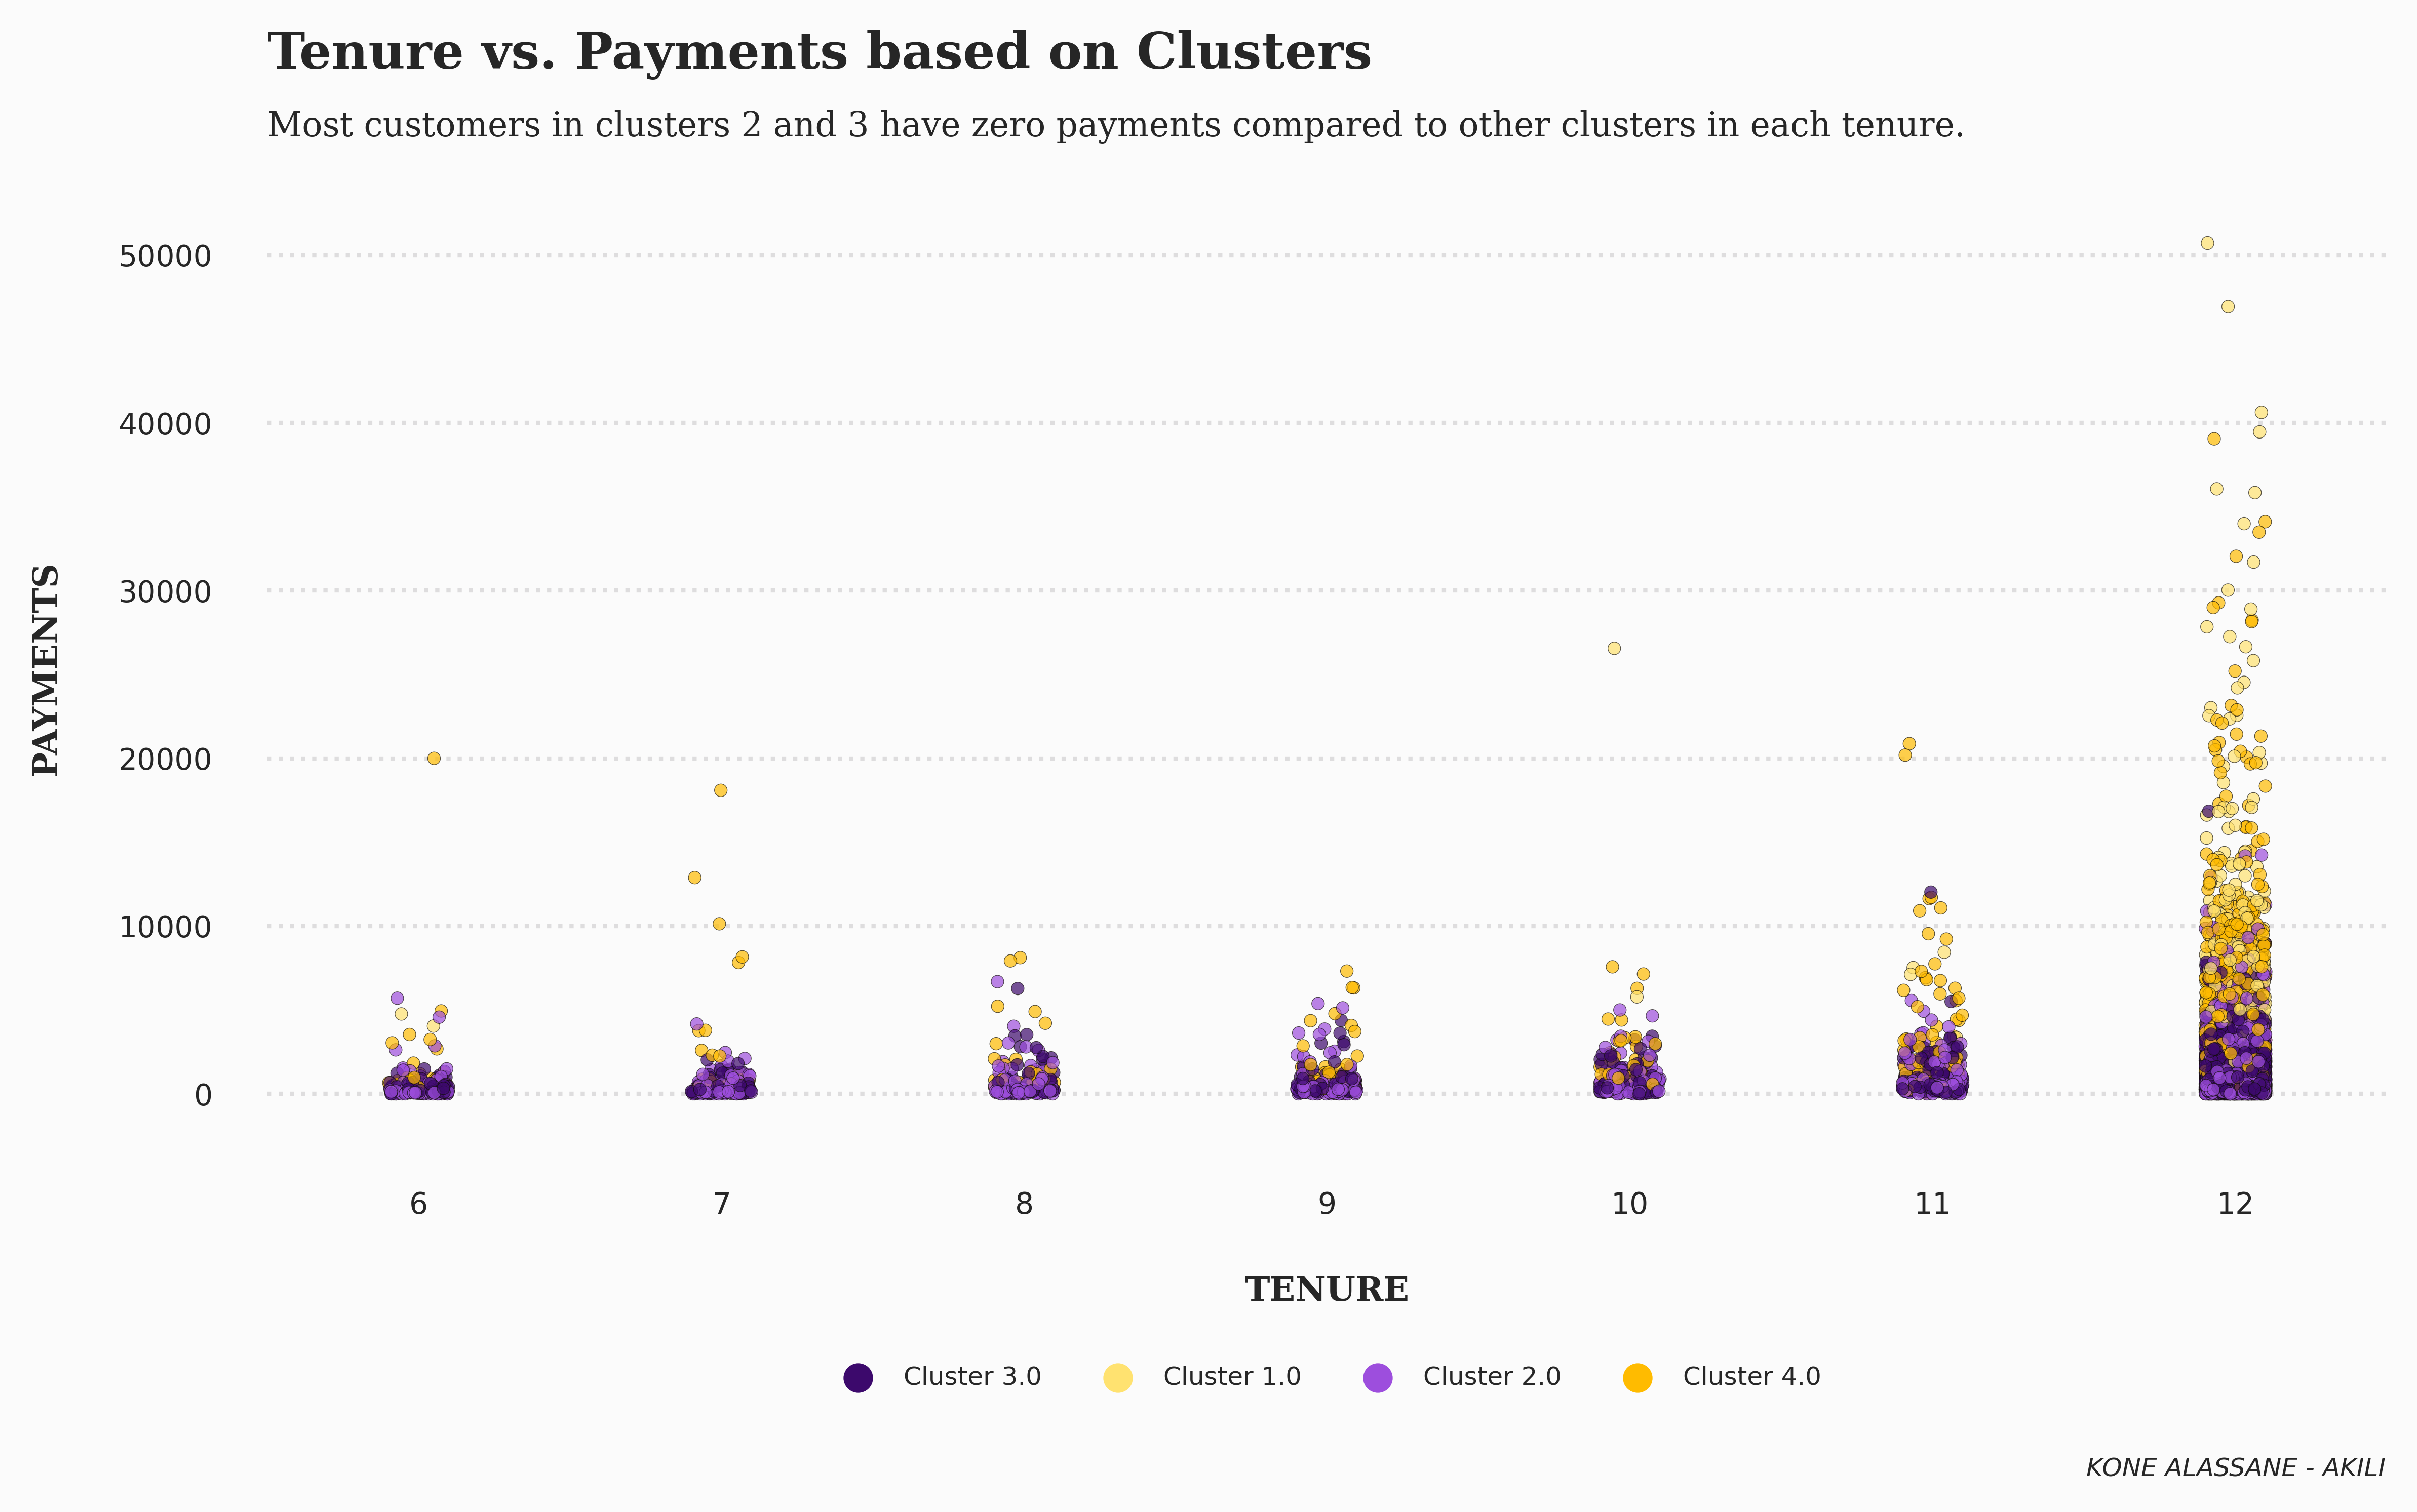

In [14]:
# --- Cluster Visualization 3: Data Frame ---
df_cv3 = df[['TENURE', 'PAYMENTS', 'cluster_result']]

# --- Cluster Visualization 3: Variables ---
color_pallete = ['#3C096C', '#FFE270', '#9D4EDD', '#FFBB00']
suptitle = dict(fontsize=12, ha='left', fontweight='heavy', fontfamily='serif')
title = dict(fontsize=8, loc='left', fontfamily='serif')
cluster_result = sorted(df_cv3['cluster_result'].unique())
stripplot_style = dict(edgecolor='#100C07', s=3, linewidth=0.15, alpha=0.7, palette=color_pallete)
legend_style = dict(ncol=5, borderpad=3, frameon=False, fontsize=6, title=None)
xy_label = dict(fontweight='bold', fontsize=8, fontfamily='serif')
grid_style = dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)

# --- Cluster Visualization 3: Visuals ---
stplot=sns.stripplot(data=df_cv3, x='TENURE', y='PAYMENTS', hue='cluster_result', **stripplot_style)
sns.move_legend(stplot, 'upper center', bbox_to_anchor=(0.5, -0.15), **legend_style)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.suptitle('Tenure vs. Payments based on Clusters', x=0.125, y=1.02, **suptitle)
plt.title('Most customers in clusters 2 and 3 have zero payments compared to other clusters in each tenure.\n', **title)
plt.xlabel('\nTENURE', **xy_label)
plt.ylabel('PAYMENTS\n', **xy_label)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(axis='x', alpha=0)
plt.grid(axis='y', **grid_style)
plt.gcf().text(0.79, -0.17, 'KONE ALASSANE - AKILI', style='italic', fontsize=6)
plt.gcf().set_size_inches(9, 4)
plt.show();

<div class="explain-box">
   <mark><b>La plupart des clients des clusters 2 et 3 ont des paiements nuls</b></mark> par rapport aux autres clusters pour chaque durée. Comme mentionné précédemment, on peut voir que <b>la plupart des clients ont tendance à choisir une durée de remboursement de 12 mois</b>.
</div>


In [ ]:
# --- Cluster Visualization 4: Data Frame ---
df_cv4 = df[['INSTALLMENTS_PURCHASES', 'CREDIT_LIMIT', 'cluster_result']]

# --- Cluster Visualization 4: Variables ---
cluster_result = sorted(df_cv4['cluster_result'].unique())
scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.75)
sub_scatter_style_color=dict(s=5, alpha=0.65, linewidth=0.15, zorder=10, edgecolor='#100C07')
sub_scatter_style_grey=dict(s=5, alpha=0.3, linewidth=0.7, zorder=5, color='#CAC9CD')
grid_style=dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
xy_label=dict(fontsize=14, fontweight='bold', fontfamily='serif')
suptitle=dict(fontsize=20, fontweight='heavy', fontfamily='serif')
title=dict(fontsize=14, fontfamily='serif')
xy_label=dict(fontweight='bold', fontsize=14, fontfamily='serif')
grid_style=dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
color_pallete=['#FFBB00', '#3C096C', '#9D4EDD', '#FFE270']
sub_axes=[None] * 4

# --- Cluster Visualization 4: Settings ---
fig = plt.figure(figsize=(21, 10))
gs = fig.add_gridspec(4, 4)
ax = fig.add_subplot(gs[:4, :4])
ax.set_aspect(1)

# --- Cluster Visualization 4: Main Scatter Plot ---
for x in range(len(cluster_result)):
    df_cv4_x = df_cv4[df_cv4['cluster_result']==cluster_result[x]]
    
    ax.scatter(df_cv4_x['CREDIT_LIMIT'], df_cv4_x['INSTALLMENTS_PURCHASES'], s=80, color=color_pallete[x], **scatter_style)
    ax.set_title('Clusters 1 and 3 are more active in making installment purchases than other clusters.\n', loc='left', **title)
    ax.set_xlabel('\nCREDIT_LIMIT', **xy_label)
    ax.set_ylabel('INSTALLMENTS_PURCHASES\n', **xy_label)
    ax.grid(axis='y', which='major', **grid_style)
    ax.grid(axis='x', which='major', **grid_style)
    for spine in ax.spines.values():
        spine.set_color('None')
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#CAC9CD')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
# --- Cluster Visualization 4: Sub Plots ---
for idx, clstr in enumerate(cluster_result):
    sub_axes[idx] = fig.add_subplot(gs[idx, 3], aspect=1)
    
    sub_axes[idx].scatter(df_cv4[df_cv4['cluster_result']!=clstr]['CREDIT_LIMIT'], df_cv4[df_cv4['cluster_result']!=clstr]['INSTALLMENTS_PURCHASES'], label=clstr, **sub_scatter_style_grey)
    sub_axes[idx].scatter(df_cv4[df_cv4['cluster_result']==clstr]['CREDIT_LIMIT'], df_cv4[df_cv4['cluster_result']==clstr]['INSTALLMENTS_PURCHASES'], color=color_pallete[idx], label=clstr, **sub_scatter_style_color)
    
    cnt = round((df_cv4['cluster_result']==clstr).sum()/8950*100, 2)
    sub_axes[idx].set_title(f'{clstr} - ({cnt}%)', loc='left', fontsize=9, fontfamily='serif')
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    for spine in sub_axes[idx].spines.values():
        spine.set_color('None')

# --- Cluster Visualization 4: Title ---
plt.suptitle('Installments Purchases vs. Credit Limit based on Clusters', x=0.273, y=0.97, ha='left', **suptitle)
plt.gcf().text(0.8, 0.01, 'KONE ALASSANE - AKILI', style='italic', fontsize=8)
plt.show();

<div class="explain-box">
 On peut constater que <mark><b>les clusters 1 et 3 ont plus d'achats à crédit que les clusters 2 et 4</b></mark>. Cependant, on peut également constater qu'un <b>grand nombre d'achats à crédit ne sont pas corrélés à l'augmentation de la limite de crédit</b>.
</div>


## <div class="header2"> Recommandations Marketing 💡</div>
<div class="explain-box">
Based on the results of the profiling above, here are some <mark><b>suggestions for marketing strategies</b></mark>:
    <blockquote style="color: #000000;">
     Les recommandations de marketing basées sur les clusters sont les suivantes :

<ul>
  <li>Les clients appartenant au <mark style="font-weight: bold; background-color: #FFBB00">cluster 1</mark> peuvent être la cible principale du marketing de cartes de crédit. Les clients de ce cluster sont très actifs dans l'utilisation de cartes de crédit, ont une durée de service et des limites de crédit les plus élevées par rapport aux autres clusters. En se concentrant sur ce cluster, les banques peuvent augmenter leurs bénéfices en utilisant des cartes de crédit plus fréquemment et en rationalisant les coûts de marketing. Les banques peuvent offrir des avantages ou des récompenses pour l'utilisation de cartes de crédit pour inciter les clients à utiliser plus souvent leurs cartes de crédit.</li> <br>

  <li>Pour les cartes de crédit spécifiques aux <mark style="font-weight: bold; background-color: #9D4EDD; color: #FFFFFF;">paiements échelonnés</mark>, les banques peuvent concentrer leur marketing sur les clients du <mark style="font-weight: bold; background-color: #9D4EDD; color: #FFFFFF;">cluster 3</mark>. Les clients de ce cluster sont plus susceptibles d'effectuer des transactions par carte de crédit à des fins d'échelonnement de paiement. Les banques peuvent offrir des programmes d'échelonnement à faible ou à 0 % d'intérêt pour différents besoins d'échelonnement aux clients de ce cluster pour les inciter à utiliser leurs cartes de crédit. Les exigences en matière d'échelonnement qui peuvent être offertes peuvent prendre la forme de paiements de voyage, d'appareils ménagers, d'appareils électroniques, de smartphones ou de certaines marques les plus demandées par le public.</li><br>

  <li>Pour le <mark style="font-weight: bold; background-color: #3C096C; color: #FFFFFF;">cluster 2</mark>, les banques peuvent offrir des cartes de crédit spéciales pour les débutants ou les étudiants <mark style="font-weight: bold; background-color: #3C096C; color: #FFFFFF;">(cartes de niveau débutant)</mark> qui peuvent manquer d'un profil de crédit étendu. Cette carte de crédit peut être utilisée pour construire leur crédit et apprendre à utiliser la carte de crédit de manière responsable. Cette carte peut inclure plusieurs fonctionnalités, telles que des frais annulés, des récompenses pour établir une routine de paiements ponctuels, des barrières faibles pour devenir titulaire de carte et des taux d'intérêt indulgents. De plus, les banques peuvent offrir des opportunités de passer à de nouveaux produits et de meilleures conditions si le client paie régulièrement ses factures à temps. En outre, les banques peuvent offrir des récompenses d'inscription pour que les clients qui ne sont pas des utilisateurs de la carte de crédit de la banque soient intéressés à s'inscrire.</li>
<br>

<li>Étant donné que les clients du <mark style="font-weight: bold; background-color: #FFE270">cluster 4</mark> ont tendance à faire des avances de fonds, les banques peuvent offrir des <mark style="font-weight: bold; background-color: #FFE270">cartes de crédit spéciales avec divers avantages</mark>. Ces avantages peuvent être sous forme de <b>faibles frais d'avance de fonds ou de frais d'administration, faible taux d'intérêt, durée relativement élevée, etc.</b>. En outre, les banques peuvent également offrir des <mark style="font-weight: bold; background-color: #FFE270">programmes bancaires autres que des cartes de crédit</mark>, tels que des <b>programmes de paiement différé en collaboration avec des tiers ou des prêts personnels fournis par les banques</b>.</li>
    </blockquote>
</div>


# <div class="header1">9. | Réferences 🔗</div>
<div class="references">
    <ul><u> Articles 🌏</u>
        <li><a style="color: #000000;" href="https://machinelearningmastery.com/clustering-algorithms-with-python/">10 Clustering Algorithms With Python by Jason Brownlee</a></li>
        <li><a style="color: #000000;" href="https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/">Hopkins Test for Cluster Tendency by ‪Matevž Kunaver</a></li>
        <li><a style="color: #000000;" href="https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891">Silhouette Method — Better than Elbow Method to find Optimal Clusters by Satyam Kumar</a></li>
        <li><a style="color: #000000;" href="https://towardsdatascience.com/credit-card-clustering-6a92657ac99">Credit Card Clustering by Charles Brecque</a></li>
        <li><a style="color: #000000;" href="https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam">KMeans Silhouette Score Explained With Python Example by Ajitesh Kumar</a></li>
        <li><a style="color: #000000;" href="https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc">DBSCAN Python Example: The Optimal Value For Epsilon (EPS) by Cory Maklin</a></li>
        <li><a style="color: #000000;" href="https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd">DBSCAN Parameter Estimation Using Python by Tara Mullin</a></li>
        <li><a style="color: #000000;" href="https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8">Hierarchical clustering explained by Prasad Pai</a></li>
        <li><a style="color: #000000;" href="https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/">A Beginner’s Guide to Hierarchical Clustering and how to Perform it in Python by Pulkit Sharma</a></li>
        <li><a style="color: #000000;" href="https://medium.com/analytics-vidhya/clustering-and-profiling-customers-using-k-means-9afa4277427">Clustering and profiling customers using K-Means by Vijay Patil</a></li>
    </ul>
    <ul><u>Autres 🔗</u>
        <li><a style="color: #000000;" href="https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency">Hopkins Statistic Clustering Tendency by Prathma Chowksey</a></li>
        <li><a style="color: #000000;" href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html">Selecting the number of clusters with silhouette analysis on KMeans clustering by Scikit Learn</a></li>
    </ul>
</div>